In [1]:
import logging
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
import functools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pvtrace import *

# Surface coatings

---
**Aside** - coating are a more advanced feature of *pvtrace* and require some knowledge of both the Python programming language and ray-optics related mathematics. The current API is not as easy to use as other areas of *pvtrace* and is subject to change in future releases.

---

Custom reflection and scattering can be included using a `SurfaceDelegate` when creating a material. You will need to create a new Python class which implements the `SurfaceDelegate` protocol (defined set of methods) to enable custom reflections or scattering at object surfaces.

```python
from pvtrace import SurfaceDelegate

class Coating(SurfaceDelegate):
    pass
    # implemented method here

Material(
    refractive_index=1.5,
    surface=Surface(delegate=Coating())
)
```

## Example of surface coating

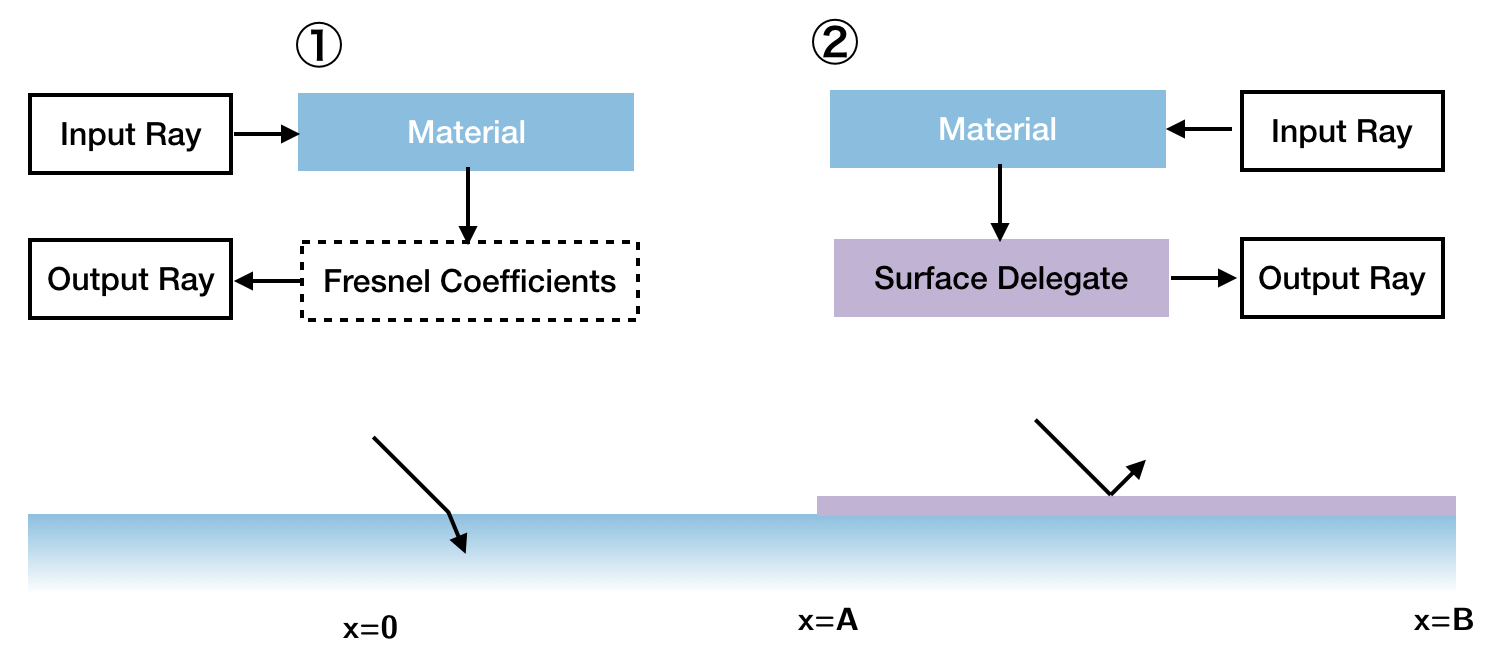

To demonstate how to use `SurfaceDelegate` we will make a plastic slab with a perfect mirrors on a small section of the top surface. All other surface are uncoated an obey the Fresnel equations. Behind the scene Frensel reflection and refraction is actually implemented using this delegate approach so we inherit from `FresnelSurfaceDelegate` and will extend it for our purpose.

In [17]:
class PartialTopSurfaceMirror(FresnelSurfaceDelegate):
    """ A section of the top surface is covered with a perfect mirrrors.
    
        All other surface obey the Fresnel equations.
    """

    def reflectivity(self, surface, ray, geometry, container, adjacent):
        """ Return the reflectivity of the part of the surface hit by the ray.
        
            Parameters
            ----------
            surface: Surface
                The surface object belonging to the material.
            ray: Ray
                The ray hitting the surface in the local coordinate system of the `geometry` object.
            geometry: Geometry
                The object being hit (e.g. Sphere, Box, Cylinder, Mesh etc.)
            container: Node
                The node containing the ray.
            adjacent: Node
                The node that will contain the ray if the ray is transmitted.
        """
        # Get the surface normal to determine which surface has been hit.
        normal = geometry.normal(ray.position)
        
        # Normal are outward facing
        TOP_SURFACE = (0, 0, 1)
        
        # If a ray hits the top surface where x > 0 and y > 0 reflection
        # set the reflectivity to 1.
        if np.allclose(normal, TOP_SURFACE):
            x, y = ray.position[0], ray.position[1]
            if x > 0 and y > 0:
                return 1.0
        
        # Otherwise return the Frensel reflection probability.
        return super(PartialTopSurfaceMirror, self).reflectivity(surface, ray, geometry, container, adjacent)  # opt-out of handling custom reflection


Make a scene and add the surface coating.

In [19]:
world = Node(
    name="world (air)",
    geometry=Box(
        (15.0, 15.0, 15.0),
        material=Material(refractive_index=1.0)
    )
)

sphere = Node(
    name="box (glass)",
    geometry=Box(
        (10.0, 10.0, 1.0),
        material=Material(
            refractive_index=1.5,
            surface=Surface(delegate=PartialTopSurfaceMirror())
        ),
    ),
    parent=world
)

ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=555.0
)

light = Node(
    name='Light',
    light=Light(
        position=functools.partial(rectangular_mask, 5, 5)
    ),
    parent=world
)
light.location = (0, 0, 2)
light.rotate(np.radians(180), (1, 0, 0))

scene = Scene(world)
np.random.seed(0)
vis = MeshcatRenderer(wireframe=True)
vis.render(scene)
for ray in scene.emit(200):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7029/static/


An implicit surface with `FresnelSurfaceDelegate` is created if no surface is supplied. 

This,

```python
material=Material(
    refractive_index=1.5,
    surface=Surface(delegate=FresnelSurfaceDelegate())
)
```

is equivalent to this,

```python
material=Material(
    refractive_index=1.5
)
```

which we can verify from running a the following,

In [22]:
world = Node(
    name="world (air)",
    geometry=Box(
        (15.0, 15.0, 15.0),
        material=Material(refractive_index=1.0)
    )
)

sphere = Node(
    name="box (glass)",
    geometry=Box(
        (10.0, 10.0, 1.0),
        material=Material(
            refractive_index=1.5,
            surface=Surface(delegate=FresnelSurfaceDelegate())
        ),
    ),
    parent=world
)

ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=555.0
)

light = Node(
    name='Light',
    light=Light(
        position=functools.partial(rectangular_mask, 5, 5)
    ),
    parent=world
)
light.location = (0, 0, 2)
light.rotate(np.radians(180), (1, 0, 0))

scene = Scene(world)
np.random.seed(0)
vis = MeshcatRenderer(wireframe=True)
vis.render(scene)
for ray in scene.emit(200):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7031/static/
